## Description

Weight Matrix construction including pseudo counts and sequence weighting

Some parts of the code have been blanked out. Fill out these places to make the code run. 

## Python Imports

In [1]:
import numpy as np
import math
import copy
from pprint import pprint

%matplotlib inline

## DEFINE THE PATH TO YOUR COURSE DATA DIRECTORY

In [2]:
data_dir = "/home/mathias/bioinfo_algos/data/"

## Define options for run

In [3]:
sequence_weighting = True
#sequence_weighting = False
# define weight on pseudo count
beta = 50 

## Data Imports

### Load Alphabet

In [4]:
alphabet_file = data_dir + "Matrices/alphabet"

alphabet = np.loadtxt(alphabet_file, dtype=str)

print (alphabet)
print (len(alphabet))

['A' 'R' 'N' 'D' 'C' 'Q' 'E' 'G' 'H' 'I' 'L' 'K' 'M' 'F' 'P' 'S' 'T' 'W'
 'Y' 'V']
20


### Load Background Frequencies

In [5]:
bg_file = data_dir + "Matrices/bg.freq.fmt"
_bg = np.loadtxt(bg_file, dtype=float)

bg = {}
for i in range(0, len(alphabet)):
    bg[alphabet[i]] = _bg[i]

bg

{'A': 0.074,
 'R': 0.052,
 'N': 0.045,
 'D': 0.054,
 'C': 0.025,
 'Q': 0.034,
 'E': 0.054,
 'G': 0.074,
 'H': 0.026,
 'I': 0.068,
 'L': 0.099,
 'K': 0.058,
 'M': 0.025,
 'F': 0.047,
 'P': 0.039,
 'S': 0.057,
 'T': 0.051,
 'W': 0.013,
 'Y': 0.032,
 'V': 0.073}

### Load Blosum62 Matrix


In [6]:
blosum62_file = data_dir + "Matrices/blosum62.freq_rownorm"
_blosum62 = np.loadtxt(blosum62_file, dtype=float).T

blosum62 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum62[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum62[letter_1][letter_2] = _blosum62[i, j]

blosum62

{'A': {'A': 0.2901,
  'R': 0.0446,
  'N': 0.0427,
  'D': 0.041,
  'C': 0.065,
  'Q': 0.0559,
  'E': 0.0552,
  'G': 0.0783,
  'H': 0.042,
  'I': 0.0471,
  'L': 0.0445,
  'K': 0.057,
  'M': 0.0522,
  'F': 0.0338,
  'P': 0.0568,
  'S': 0.1099,
  'T': 0.073,
  'W': 0.0303,
  'Y': 0.0405,
  'V': 0.07},
 'R': {'A': 0.031,
  'R': 0.345,
  'N': 0.0449,
  'D': 0.0299,
  'C': 0.0163,
  'Q': 0.0735,
  'E': 0.0497,
  'G': 0.0229,
  'H': 0.0458,
  'I': 0.0177,
  'L': 0.0243,
  'K': 0.1071,
  'M': 0.0321,
  'F': 0.019,
  'P': 0.0258,
  'S': 0.0401,
  'T': 0.0355,
  'W': 0.0227,
  'Y': 0.028,
  'V': 0.0219},
 'N': {'A': 0.0256,
  'R': 0.0388,
  'N': 0.3169,
  'D': 0.069,
  'C': 0.0163,
  'Q': 0.0441,
  'E': 0.0405,
  'G': 0.0391,
  'H': 0.0534,
  'I': 0.0147,
  'L': 0.0142,
  'K': 0.0415,
  'M': 0.0201,
  'F': 0.0169,
  'P': 0.0233,
  'S': 0.0541,
  'T': 0.0434,
  'W': 0.0152,
  'Y': 0.0218,
  'V': 0.0165},
 'D': {'A': 0.0297,
  'R': 0.031,
  'N': 0.0831,
  'D': 0.3974,
  'C': 0.0163,
  'Q': 0.0471,


### Load Peptides

In [7]:
#peptides_file = data_dir + "PSSM/A0201.single_lig"
#peptides_file = data_dir + "PSSM/A0201.small_lig"
peptides_file = data_dir + "PSSM/A0201.large_lig"

peptides = np.loadtxt(peptides_file, dtype=str).tolist()

if len(peptides[0]) == 1:
    peptide_length = len(peptides)
    peptides = [peptides]
else:
    peptide_length = len(peptides[0])

for i in range(0, len(peptides)):
    if len(peptides[i]) != peptide_length:
        print("Error, peptides differ in length!")
        
print(peptides)

['SLLPAIVEL', 'YLLPAIVHI', 'TLWVDPYEV', 'SLPSGGAGV', 'GLVPFLVSV', 'KLLEPVLLL', 'LLDVPTAAV', 'LLDVPTAAV', 'LLDVPTAAV', 'LLDVPTAAV', 'VLFRGGPRG', 'MVDGTLLLL', 'YMNGTMSQV', 'MLLSVPLLL', 'SLLGLLVEV', 'ALLPPINIL', 'TLIKIQHTL', 'ALIVGANDD', 'HLIDYLVTS', 'ILAPPVVKL', 'ALFPQLVIL', 'GILGFVFTL', 'STNRQSGRQ', 'ASKKFDQSQ', 'AQYTSRMIA', 'GLDVLTAKV', 'RILGAVAKV', 'QVCERIPTI', 'ILFGHENRV', 'ILMEHIHKL', 'ILDQKINEV', 'SLAGGIIGV', 'LLIENVASL', 'FLLWATAEA', 'SLPDFGISY', 'ALIDFALYL', 'KKREEAPSL', 'LERPGGNEI', 'ALSNLEVKL', 'ALNELLQHV', 'DLERKVESL', 'FLGENISNF', 'ALSDHHIYL', 'GLSEFTEYL', 'STAPPAHGV', 'PLDGEYFTL', 'GVLVGVALI', 'RTLDKVLEV', 'HLSTAFARV', 'RLDSYVRSL', 'YMNGTMSQV', 'GILGFVFTL', 'ALWGFFPVL', 'ILKEPVHGV', 'ILGFVFTLT', 'LLFGYPVYV', 'GLSPTVWLS', 'WLSLLVPFV', 'FLPSDFFPS', 'CLGGLLTMV', 'FIAGNSAYE', 'KLGEFYNQM', 'KLVALGINA', 'DLMGYIPLV', 'RLVTLKDIV', 'MLLAVLYCL', 'AAGIGILTV', 'YLEPGPVTA', 'LLDGTATLR', 'ITDQVPFSV', 'KTWGQYWQV', 'TITDQVPFS', 'AFHHVAREL', 'YLNKIQNSL', 'MMRKLAILS', 'AIMDKNIIL', 'IMDKNIILK'

## Initialize Matrix

In [8]:
def initialize_matrix(peptide_length, alphabet):

    init_matrix = [0]*peptide_length

    for i in range(0, peptide_length):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix

## Amino Acid Count Matrix (c)

In [9]:
c_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
        
    for peptide in peptides:
        
        c_matrix[position][peptide[position]] += 1
    
pprint(c_matrix[0])

{'A': 27.0,
 'C': 3.0,
 'D': 4.0,
 'E': 5.0,
 'F': 18.0,
 'G': 19.0,
 'H': 3.0,
 'I': 17.0,
 'K': 14.0,
 'L': 24.0,
 'M': 9.0,
 'N': 2.0,
 'P': 3.0,
 'Q': 4.0,
 'R': 13.0,
 'S': 26.0,
 'T': 7.0,
 'V': 18.0,
 'W': 1.0,
 'Y': 12.0}


## Sequence Weighting

In [10]:
# w = 1 / r * s
# where 
# r = number of different amino acids in column
# s = number of occurrence of amino acid in column

weights = {}

for peptide in peptides:

    # apply sequence weighting
    if sequence_weighting:
    
        w = 0.0
        neff = 0.0
        
        for position in range(0, peptide_length):

            r = 0

            for letter in alphabet:        

                if c_matrix[position][letter] != 0:
                    
                    r += 1

            s = c_matrix[position][peptide[position]]

            w += 1.0/(r * s)

            neff += r
                
        neff = neff / peptide_length
  
    # do not apply sequence weighting
    else:
        
        w = 1  
        
        neff = len(peptides)  
      

    weights[peptide] = w

pprint( "W:")
pprint( weights )
pprint( "Nseq:")
pprint( neff )

'W:'
{'AAGIGIIQI': 0.024596541281685157,
 'AAGIGILTV': 0.017794374930590016,
 'ACDPHSGHF': 0.11606701877986708,
 'AFHHVAREL': 0.16762478444633447,
 'AIMDKNIIL': 0.03675033603899132,
 'ALCRWGLLL': 0.038316106033513334,
 'ALFPQLVIL': 0.0247039614348667,
 'ALGLGLLPV': 0.01930023126571007,
 'ALIDFALYL': 0.025263578835188177,
 'ALIVGANDD': 0.100611436744236,
 'ALLPPINIL': 0.022592294366303084,
 'ALNELLQHV': 0.03213666839007289,
 'ALQPGTALL': 0.025789304539119713,
 'ALSDHHIYL': 0.03531896462586808,
 'ALSNLEVKL': 0.037730526017692625,
 'ALWGFFPVL': 0.024805842986585454,
 'ALYVDSLFF': 0.042787268993597666,
 'AQYTSRMIA': 0.10924718135995681,
 'ASKKFDQSQ': 0.09142827452618475,
 'AVFDRKSDA': 0.05167458625640195,
 'AVGIGIAVV': 0.02107323439396396,
 'AVPDEIPPL': 0.026045581915119548,
 'CINGVCWTV': 0.049096156193671595,
 'CLGGLLTMV': 0.04386581500312044,
 'CLTSTVQLV': 0.040561312437441883,
 'DLERKVESL': 0.05248292990322345,
 'DLMGYIPLV': 0.03314102718433929,
 'DTVLEEMNL': 0.05099854032009033,
 'DVKQ

## Observed Frequencies Matrix (f)

In [11]:
f_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
  
    n = 0;
  
    for peptide in peptides:
    
        f_matrix[position][peptide[position]] += weights[peptide]
    
        n += weights[peptide]
        
    for letter in alphabet: 
        
        f_matrix[position][letter] = f_matrix[position][letter]/n
      
pprint( f_matrix[0] )

{'A': 0.1311811080905332,
 'C': 0.014835920403803767,
 'D': 0.020983592174332863,
 'E': 0.027946724738341398,
 'F': 0.06424458205659711,
 'G': 0.0627520000996758,
 'H': 0.015299356996921818,
 'I': 0.06970270278930987,
 'K': 0.06294576946390068,
 'L': 0.09425526545382713,
 'M': 0.0376436000084843,
 'N': 0.013196906736333046,
 'P': 0.02139872688992593,
 'Q': 0.020192724448129442,
 'R': 0.05470935070055924,
 'S': 0.09446933607455794,
 'T': 0.03891306967870277,
 'V': 0.09865737399939828,
 'W': 0.008014705876770572,
 'Y': 0.048657183319894895}


## Pseudo Frequencies Matrix (g)

Remember g(b) = sum f(a)* q(b|a), and blosum[a,b] = q(a|b)

In [12]:
g_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):

    for letter_1 in alphabet:
        for letter_2 in alphabet:
        
          g_matrix[position][letter_2] += f_matrix[position][letter_1]*blosum62[letter_2][letter_1]

pprint(g_matrix[0])

{'A': 0.08987082139366394,
 'C': 0.021349452415678354,
 'D': 0.03809148889713515,
 'E': 0.04474699977471958,
 'F': 0.05630852882264416,
 'G': 0.07026655815709919,
 'H': 0.02212768473312947,
 'I': 0.07445249100074502,
 'K': 0.0572838265712342,
 'L': 0.10508273163109474,
 'M': 0.027841477841683355,
 'N': 0.0335719618182939,
 'P': 0.030884895328302287,
 'Q': 0.030191793024707318,
 'R': 0.05153525745245067,
 'S': 0.06340023795275433,
 'T': 0.05062316759683184,
 'V': 0.0827831198777054,
 'W': 0.011374105618283127,
 'Y': 0.03820804536044906}


## Combined Frequencies Matrix (p)

In [13]:
p_matrix = initialize_matrix(peptide_length, alphabet)

alpha = neff - 1

for position in range(0, peptide_length):

    for a in alphabet:
        p_matrix[position][a] = (alpha*f_matrix[position][a]+beta*g_matrix[position][a])/(alpha+beta)

pprint(p_matrix[0])

{'A': 0.10080589728401168,
 'C': 0.019625282177240966,
 'D': 0.033562927999922776,
 'E': 0.040299868147443005,
 'F': 0.05840924879633759,
 'G': 0.06827741043601654,
 'H': 0.02032018621472156,
 'I': 0.07319519412124749,
 'K': 0.058782576160469446,
 'L': 0.1022166376429945,
 'M': 0.03043615723877772,
 'N': 0.028178564884833678,
 'P': 0.028373850741673253,
 'Q': 0.027544980754436704,
 'R': 0.05237545860636176,
 'S': 0.07162441098499647,
 'T': 0.047523435794974145,
 'V': 0.08698512832168293,
 'W': 0.010484852745529804,
 'Y': 0.04097399364383178}


## Log Odds Weight Matrix (w)

In [14]:
w_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
    
    for letter in alphabet:
        if p_matrix[position][letter] > 0:
            w_matrix[position][letter] = 2 * math.log(p_matrix[position][letter]/bg[letter])/math.log(2)
        else:
            w_matrix[position][letter] = -999.9

pprint(w_matrix[0])

{'A': 0.8919657302038987,
 'C': -0.6984293946039517,
 'D': -1.3721816531573625,
 'E': -0.8443685774100588,
 'F': 0.627072147100672,
 'G': -0.23223385714680514,
 'H': -0.7111960003754546,
 'I': 0.2124283604386675,
 'K': 0.03867137317999952,
 'L': 0.09225922061967673,
 'M': 0.5677162517897559,
 'N': -1.3506537268042555,
 'P': -0.917824331009928,
 'Q': -0.6074905829292724,
 'R': 0.020758696079847507,
 'S': 0.6589789008068409,
 'T': -0.20371620971979315,
 'V': 0.5057446065687232,
 'W': -0.6204100472027255,
 'Y': 0.7132732216574992}


### Write Matrix to PSI-BLAST format

In [15]:
def to_psi_blast(matrix):

    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 

### convert w_matrix to PSI-BLAST format and print to file

In [16]:
def to_psi_blast_file(matrix, file_name):
    
    with open(file_name, 'w') as file:

        header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        file.write ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*header)) 

        letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        for i, row in enumerate(matrix):

            scores = []

            scores.append(str(i+1) + " A")

            for letter in letter_order:

                score = row[letter]

                scores.append(round(score, 4))

            file.write('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*scores)) 

### convert  w_matrix to PSI-BLAST format

In [17]:
to_psi_blast(w_matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A    0.892   0.0208  -1.3507  -1.3722  -0.6984  -0.6075  -0.8444  -0.2322  -0.7112   0.2124   0.0923   0.0387   0.5677   0.6271  -0.9178    0.659  -0.2037  -0.6204   0.7133   0.5057
 2 A  -0.5482  -2.7274  -3.2548  -2.8503  -0.6856  -1.6398  -2.3204  -2.5016  -3.0955   1.0746   3.5851  -1.9965   2.1613  -0.2288  -3.2982  -1.6106  -0.0476  -2.6603  -1.1592   0.6709
 3 A  -0.1166  -0.5277   0.3618   0.9364  -0.2533  -0.6813  -0.9469   0.3371   0.6811  -0.7243  -0.2846  -0.9304   0.1852   0.3262    0.624  -0.0003  -0.0853   2.1174   0.9275   -0.329
 4 A   -0.088  -0.2825  -0.6485   1.4619   -1.189   0.3638   0.5423   1.1447  -0.5074  -0.4884  -1.1798  -0.2064  -0.9622  -1.1056   1.7528   0.3107  -0.0102   0.9596  -2.2459  -0.6885
 5 A  -0.7633  -0.2185  -0.1524   -0.753  -1.2315   0.0801  -0.0375   1.369

### convert w_matrix to PSI-BLAST format and print to file

In [18]:
# Write out PSSM in Psi-Blast format to file
file_name = "w_matrix_test"
to_psi_blast_file(w_matrix, file_name)

## Evaluation

In [19]:
#evaluation_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_2/A0201.eval"
evaluation_file = data_dir + "PSSM/A0201.eval"
#evaluation_file = evaluation_upload.values()

evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,2)
evaluation_peptides = evaluation[:, 0]
evaluation_targets = evaluation[:, 1].astype(float)

evaluation_peptides, evaluation_targets

(array(['ILYQVPFSV', 'VVMGTLVAL', 'ILDEAYVMA', ..., 'FARGVVHVI',
        'LQRELTRLQ', 'AVAEEMTKS'], dtype='<U9'),
 array([0.8532, 0.5891, 0.4941, ..., 0.    , 0.    , 0.    ]))

In [20]:
def score_peptide(peptide, matrix):
    acum = 0
    for i in range(0, len(peptide)):
        acum += matrix[i][peptide[i]]
    return acum

In [21]:
evaluation_predictions = []
for evaluation_peptide in evaluation_peptides:
    evaluation_predictions.append(score_peptide(evaluation_peptide, w_matrix))

PCC:  0.7014815027715359


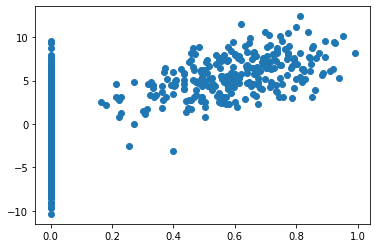

In [22]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pcc = pearsonr(evaluation_targets, evaluation_predictions)
print("PCC: ", pcc[0])

plt.scatter(evaluation_targets, evaluation_predictions);